In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

C:\Users\hcurtis\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Overall prescribing

## Import data

In [2]:
q = '''
SELECT
  p.practice,
  pct,
  prac.setting,
  p.month,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050113',items,0)) AS uti_items,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050103',items,0)) AS tetracyclines,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050108',items,0)) AS sulphonamides_trimethoprim,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0',items,0)) AS coamoxiclav,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050102',items,0)) AS cephalosporins,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS quinolones,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050105',items,0)) AS macrolides,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050111',items,0)) AS metroni_tini_ornidazole,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050101',items,0)) AS penicillins,
  SUM(IF(SUBSTR(p.bnf_code,1,9) IN ('0501012G0','0501012H0'),items,0)) AS flucloxacillin,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS all_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6) IN ('050112','050113','050103','050105','050111','050101'),items,0)) AS denom_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050110',items,0)) AS antileprotic,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050109',items,0)) AS antituberculosis,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050107',items,0)) AS some_other_antibacterials,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050104',items,0)) AS aminogylcosides,
  SUM(IF(SUBSTR(p.bnf_code,1,9) IN ('0501013C0','0501013F0','0501013E0','0501013B0'),items,0)) AS amoxicillin,
  SUM(items) AS items,
  SUM(IF((p.bnf_code like'0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD' 
    OR p.bnf_code LIKE '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.quantity,0) 
    * r.percent_of_adq) AS numerator_uti_course,
   SUM(IF((p.bnf_code like '0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD'
    OR p.bnf_code like '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.items,0)) AS denominator_uti_course,
  AVG(total_list_size) AS list_size,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_item') AS FLOAT64) AS star_pu_items
FROM
  ebmdatalab.alex.antibiotic_prescribing p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND (prac.setting = 4
  OR prac.setting = 2)
LEFT JOIN
  ebmdatalab.alex.practice_statistics_all_years_really stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
LEFT JOIN
  ebmdatalab.hscic.presentation r
ON
  p.bnf_code = r.bnf_code
GROUP BY
  practice,
  pct,
  setting,
  month
ORDER BY
  practice,
  month
'''

all_antibiotics = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
ooh = all_antibiotics.loc[all_antibiotics.setting==2]
all_antibiotics = all_antibiotics.loc[all_antibiotics.setting==4]
all_antibiotics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698489 entries, 0 to 715285
Data columns (total 26 columns):
practice                      698489 non-null object
pct                           698489 non-null object
setting                       698489 non-null int32
month                         698489 non-null datetime64[ns]
uti_items                     698489 non-null int32
tetracyclines                 698489 non-null int32
sulphonamides_trimethoprim    698489 non-null int32
coamoxiclav                   698489 non-null int32
cephalosporins                698489 non-null int32
quinolones                    698489 non-null int32
macrolides                    698489 non-null int32
metroni_tini_ornidazole       698489 non-null int32
penicillins                   698489 non-null int32
flucloxacillin                698489 non-null int32
all_broad_spectrum            698489 non-null int32
denom_broad_spectrum          698489 non-null int32
antileprotic                  698489 non-null 

In [3]:
pc = all_antibiotics.copy()

pc["percent_broad_spec"] = 100*(pc.all_broad_spectrum/pc.denom_broad_spectrum).fillna(0)
# deal with nulls
pc["three_day_courses"] = (pc.numerator_uti_course/pc.denominator_uti_course).fillna(0)
pc = pc.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc:
    if (pc[column].dtype == np.float64) | (pc[column].dtype == np.int32):
        pc["%s_per_thousand"%column] = pc[column]/(pc["list_size"]/1000)
    else:
        pc[column] = pc[column]
pc["items_per_starpu"] = pc["items"]/(pc["star_pu_items"]/1000)
        
pc = pc.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)
pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698489 entries, 0 to 715285
Data columns (total 42 columns):
practice                                   698489 non-null object
pct                                        698489 non-null object
setting                                    698489 non-null int32
month                                      698489 non-null datetime64[ns]
uti_items                                  698489 non-null int32
tetracyclines                              698489 non-null int32
sulphonamides_trimethoprim                 698489 non-null int32
coamoxiclav                                698489 non-null int32
cephalosporins                             698489 non-null int32
quinolones                                 698489 non-null int32
macrolides                                 698489 non-null int32
metroni_tini_ornidazole                    698489 non-null int32
penicillins                                698489 non-null int32
flucloxacillin                   

In [4]:
pc.practice.drop_duplicates().count()

8173

### Calculations and percentiles

In [5]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (~pd.isnull(pc.star_pu_items)) & (pc["month"]>"2010-09-01") ]
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
pcf = filtered.groupby('month').quantile(x)
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head()

,month,percentile,aminogylcosides,aminogylcosides_per_thousand,amoxicillin,amoxicillin_per_thousand,antileprotic,antileprotic_per_thousand,antituberculosis,antituberculosis_per_thousand,...,some_other_antibacterials,some_other_antibacterials_per_thousand,star_pu_items,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_thousand,tetracyclines,tetracyclines_per_thousand,three_day_courses,uti_items,uti_items_per_thousand
0,2010-10-01,0.1,0.0,0.0,38.0,9.722523,0.0,0.0,0.0,0.0,...,0.0,0.0,1285.021141,8.0,2.395497,7.0,2.008960,4.863636,1.0,0.326371
1,2010-10-01,0.2,0.0,0.0,54.0,11.820060,0.0,0.0,0.0,0.0,...,0.0,0.0,1741.449384,13.0,3.302912,12.0,2.772643,5.367647,3.0,0.628634
2,2010-10-01,0.3,0.0,0.0,68.0,13.374040,0.0,0.0,0.0,0.0,...,0.0,0.0,2227.098062,18.0,4.010169,16.0,3.430532,5.709112,5.0,0.927650
3,2010-10-01,0.4,0.0,0.0,83.0,14.779781,0.0,0.0,0.0,0.0,...,0.0,0.0,2781.836536,24.0,4.576160,22.0,4.024497,6.023256,7.0,1.225302
4,2010-10-01,0.5,0.0,0.0,99.0,16.226702,0.0,0.0,0.0,0.0,...,0.0,0.0,3393.865396,31.0,5.122884,28.0,4.630395,6.333333,9.0,1.534527


In [6]:
filtered.practice.drop_duplicates().count()

8052

## Practice level plots

### Without smoothing

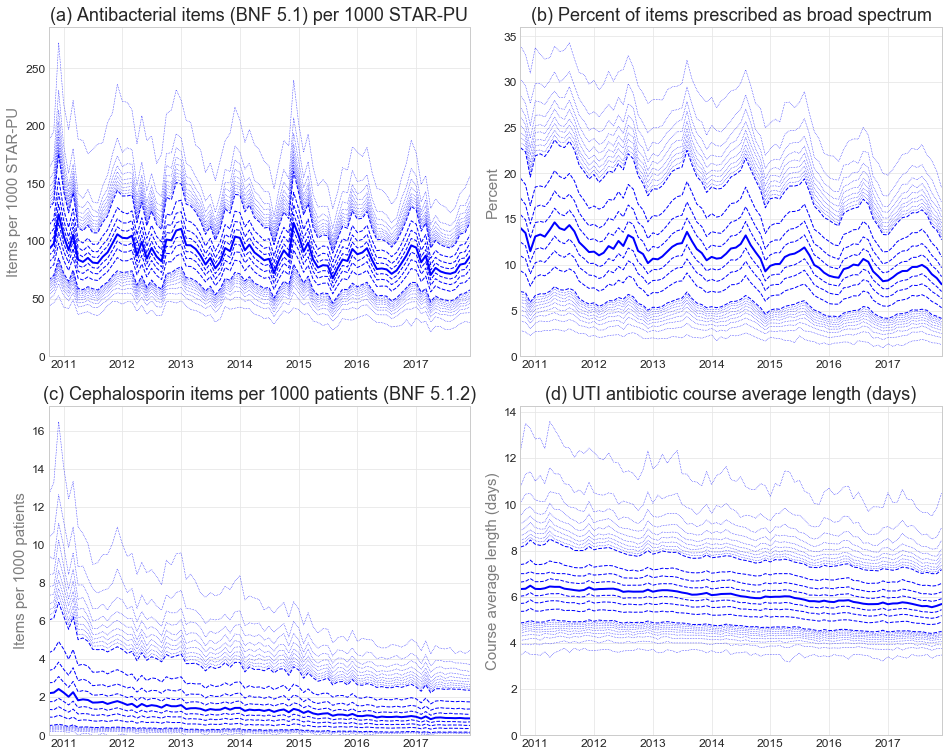

In [7]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per 1000 STAR-PU','Items per 1000 STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Percent of items prescribed as broad spectrum','Percent'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients (BNF 5.1.2)','Items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)', 'Course average length (days)')]
x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### WIth smoothing

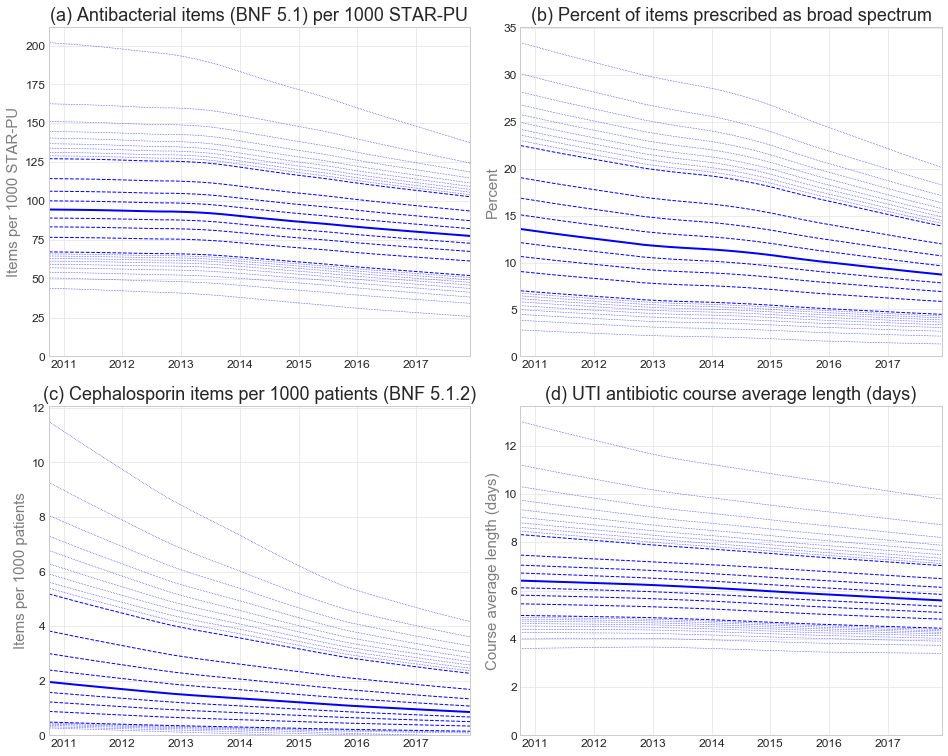

In [8]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per 1000 STAR-PU','Items per 1000 STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Percent of items prescribed as broad spectrum','Percent'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients (BNF 5.1.2)','Items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)', 'Course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots
smry = pd.DataFrame(dfp.dates.drop_duplicates().reset_index(drop=True)) # set up df for outputing results into a table

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
            smry[i[1]]= res.reset_index()[i[1]]
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, res.max()[0]*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


### Stratified by chapter

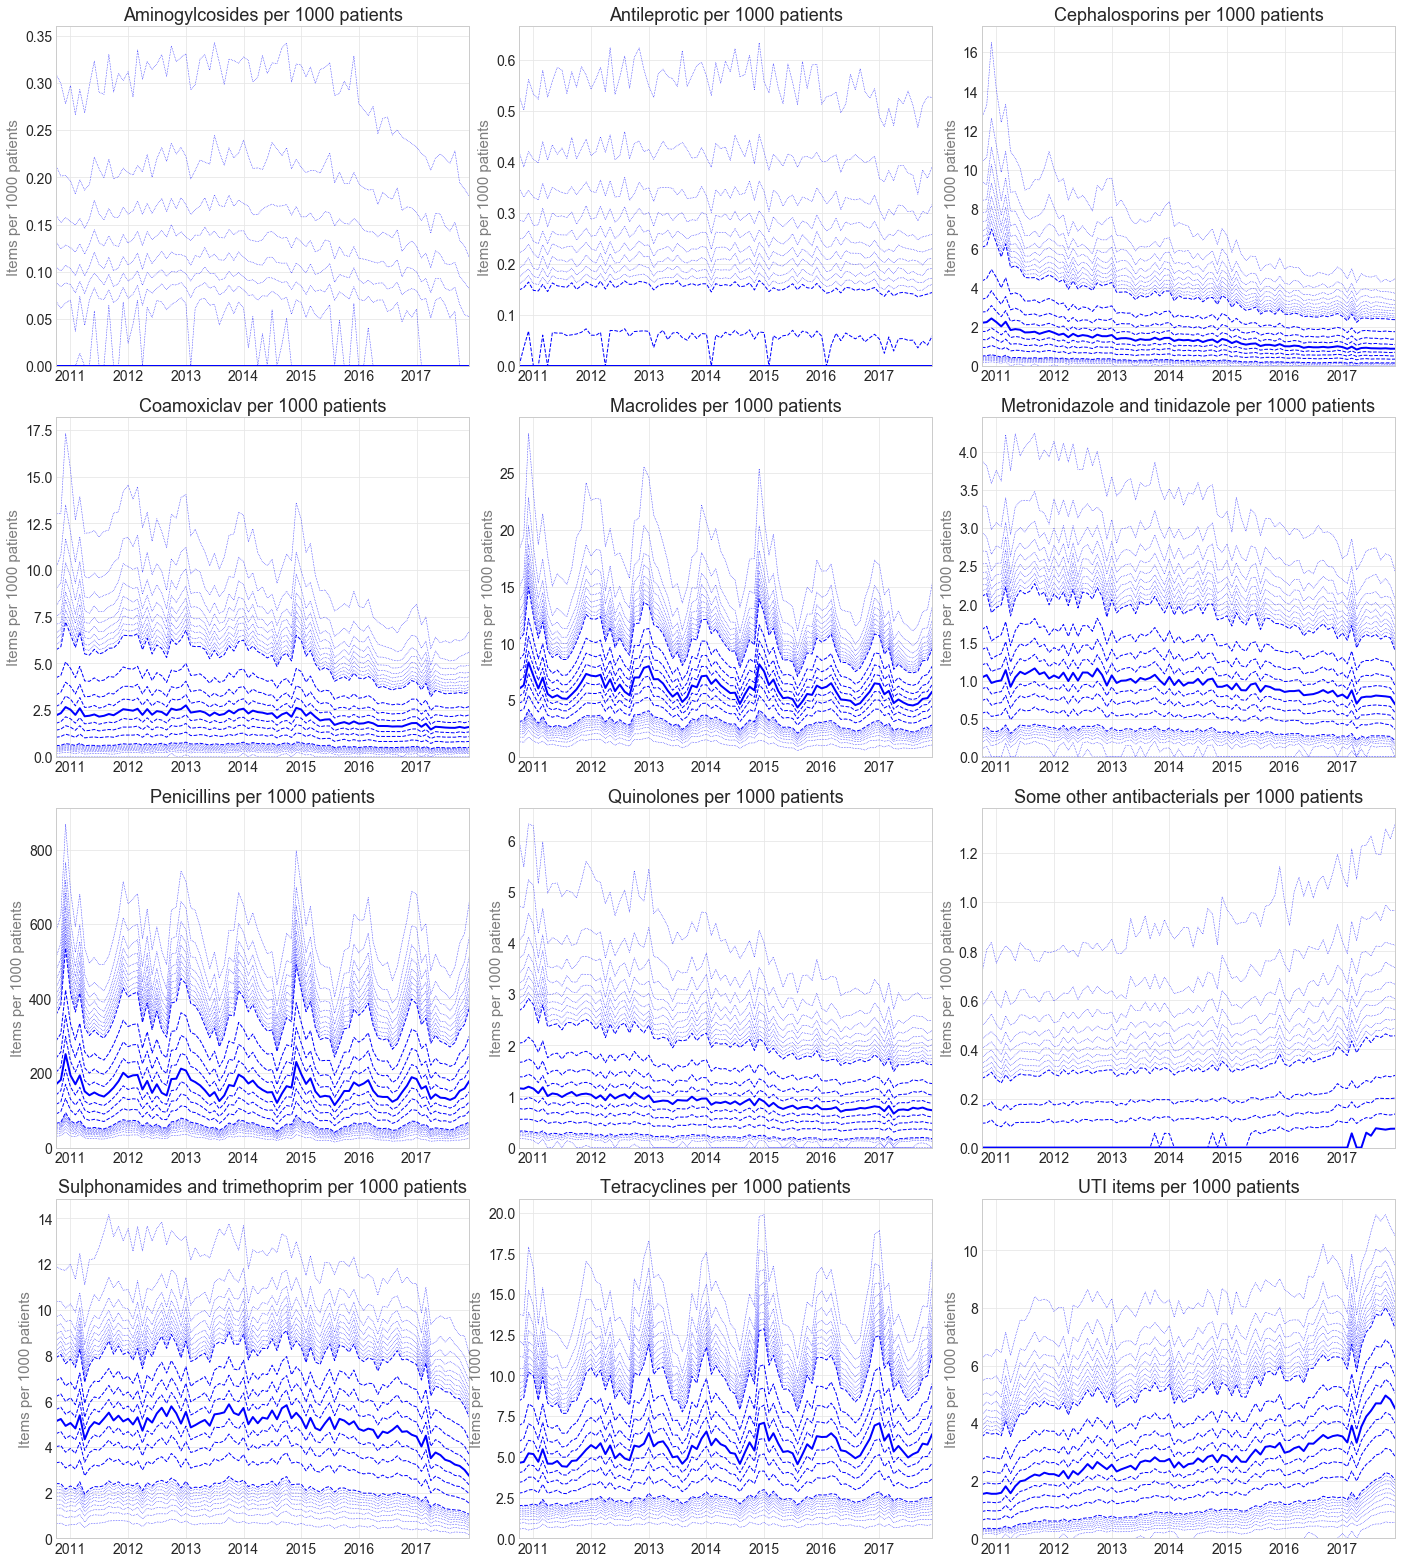

In [9]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'aminogylcosides_per_thousand',0,0,'Aminogylcosides per 1000 patients'), 
     (1,'antileprotic_per_thousand',0,1,'Antileprotic per 1000 patients'),
     (2,'cephalosporins_per_thousand',0,2,'Cephalosporins per 1000 patients'),
     (3,'coamoxiclav_per_thousand',1,0, 'Coamoxiclav per 1000 patients'),
     (4,'macrolides_per_thousand',1,1, 'Macrolides per 1000 patients'),
     (5,'metroni_tini_ornidazole_per_thousand',1,2, 'Metronidazole and tinidazole per 1000 patients'),
     (6,'penicillins',2,0,'Penicillins per 1000 patients'),
     (7,'quinolones_per_thousand',2,1, 'Quinolones per 1000 patients'),
     (8,'some_other_antibacterials_per_thousand',2,2, 'Some other antibacterials per 1000 patients'),
     (9,'sulphonamides_trimethoprim_per_thousand',3,0, 'Sulphonamides and trimethoprim per 1000 patients'),
     (10,'tetracyclines_per_thousand',3,1, 'Tetracyclines per 1000 patients'),
     (11,'uti_items_per_thousand',3,2, 'UTI items per 1000 patients')
    ]
x = pd.Series(x)

fig = plt.figure(figsize=(24,35)) 
gs = gridspec.GridSpec(5,3)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        #res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel("Items per 1000 patients", size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_appendices.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# OOH

In [10]:
pc_ooh = ooh.copy()

pc_ooh["percent_broad_spec"] = 100*(pc_ooh.all_broad_spectrum/pc_ooh.denom_broad_spectrum).fillna(0)
# deal with nulls
pc_ooh["three_day_courses"] = (pc_ooh.numerator_uti_course/pc_ooh.denominator_uti_course).fillna(0)
pc_ooh = pc_ooh.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc_ooh:
    if (pc_ooh[column].dtype == np.float64) | (pc_ooh[column].dtype == np.int32):
        pc_ooh["%s_per_thousand"%column] = pc_ooh[column]/(pc_ooh["list_size"]/1000)
    else:
        pc_ooh[column] = pc_ooh[column]
pc_ooh["items_per_starpu"] = pc_ooh["items"]/(pc_ooh["star_pu_items"]/1000)
        
pc_ooh = pc_ooh.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)

# filter for minimum prescribing level (50 items/month)
filtered_ooh = pc_ooh.copy().loc[pc_ooh['items']>50]

x = np.arange(0.1, 1, 0.1)
pcf_ooh = filtered_ooh.groupby('month').quantile(x)
pcf_ooh = pcf_ooh.reset_index().rename(columns={"level_1": 'percentile'})
pcf_ooh.head(20)


pc_ooh.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4392: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16809 entries, 27829 to 715297
Data columns (total 42 columns):
practice                                   16809 non-null object
pct                                        16809 non-null object
setting                                    16809 non-null int32
month                                      16809 non-null datetime64[ns]
uti_items                                  16809 non-null int32
tetracyclines                              16809 non-null int32
sulphonamides_trimethoprim                 16809 non-null int32
coamoxiclav                                16809 non-null int32
cephalosporins                             16809 non-null int32
quinolones                                 16809 non-null int32
macrolides                                 16809 non-null int32
metroni_tini_ornidazole                    16809 non-null int32
penicillins                                16809 non-null int32
flucloxacillin                             

In [11]:
filtered_ooh.practice.drop_duplicates().count()

260

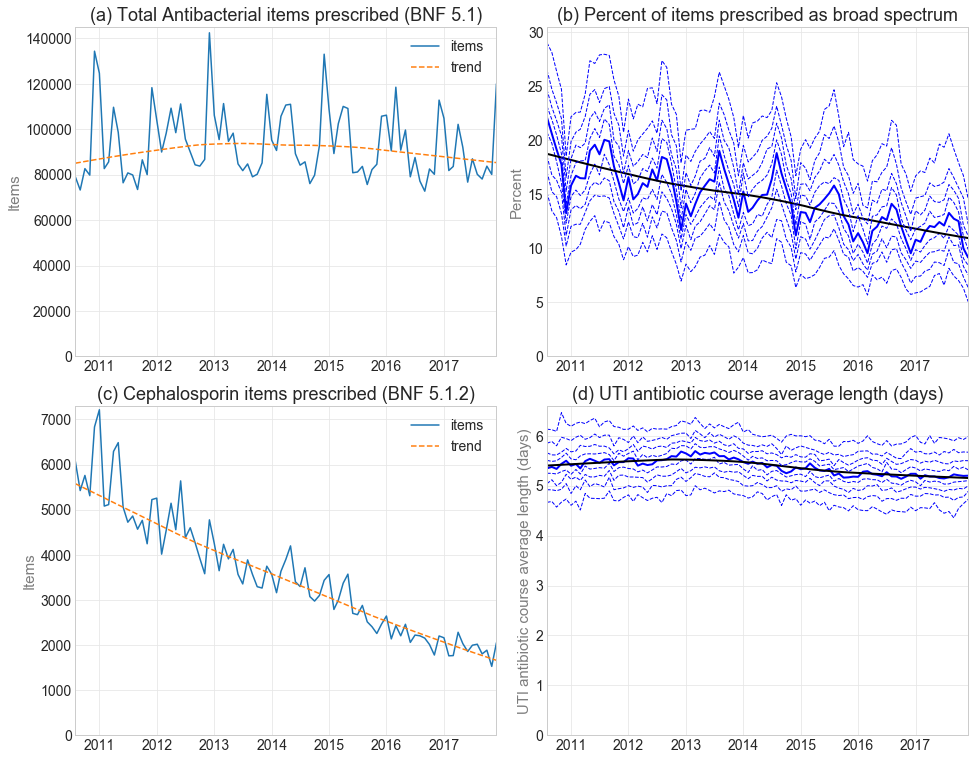

In [12]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf_ooh.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
#data = ooh.loc[all_antibiotics["month"]>"2010-09-01"]
data = ooh.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100
ooh_t = data

ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(a) Total Antibacterial items prescribed (BNF 5.1)',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,145000])
ax.legend(prop={'size': 14})

'''ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.savefig('seasonal_variation_total.png', format='png', dpi=300,bbox_inches='tight')
plt.show()
'''
###########
ax = plt.subplot(gs[0,1])  # position of subplot in grid using coordinates listed in s
for decile in x:   # plot each decile line
    data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    res = data['percent_broad_spec']
    #res = seasonal_decompose(res, model='additive') # cruder smoothing
    #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
    #res = res.trend

    if decile == .5:
        ax.plot(data["dates"],res,'b-',linewidth=2)
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        ax.plot(data["dates"],res,'k-',linewidth=2)
        ooh_perc= res.reset_index()
    elif (decile <0.1) | (decile >0.9):
        ax.plot(data["dates"],res,'b:',linewidth=0.6)
    else:
        ax.plot(data["dates"],res,'b--',linewidth=1)
ax.set_ylabel('Percent', size =15, alpha=0.6)
ax.set_title('(b) Percent of items prescribed as broad spectrum',size = 18),
ax.set_ylim([0, data['percent_broad_spec'].max()*1.05])  # set ymax across all subplots as largest value across dataset
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range


##########
ax = plt.subplot(gs[1,0])
data = ooh.groupby('month').sum()[['cephalosporins','list_size']]
data = pd.DataFrame(data['cephalosporins'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100
ooh_ceph = data

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(c) Cephalosporin items prescribed (BNF 5.1.2)',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,7300])
ax.legend(prop={'size': 14})

###########
ax = plt.subplot(gs[1,1])  # position of subplot in grid using coordinates listed in s
for decile in x:   # plot each decile line
    data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    res = data['three_day_courses']
    #res = seasonal_decompose(res, model='additive') # cruder smoothing
    #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
    #res = res.trend

    if decile == .5:
        ax.plot(data["dates"],res,'b-',linewidth=2)
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        ax.plot(data["dates"],res,'k-',linewidth=2)
    elif (decile <0.1) | (decile >0.9):
        ax.plot(data["dates"],res,'b:',linewidth=0.6)
    else:
        ax.plot(data["dates"],res,'b--',linewidth=1)
ax.set_ylabel('UTI antibiotic course average length (days)', size =15, alpha=0.6)
ax.set_title('(d) UTI antibiotic course average length (days)',size = 18)
ax.set_ylim([0, 6.6])  # set ymax across all subplots as largest value across dataset
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('OOH.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


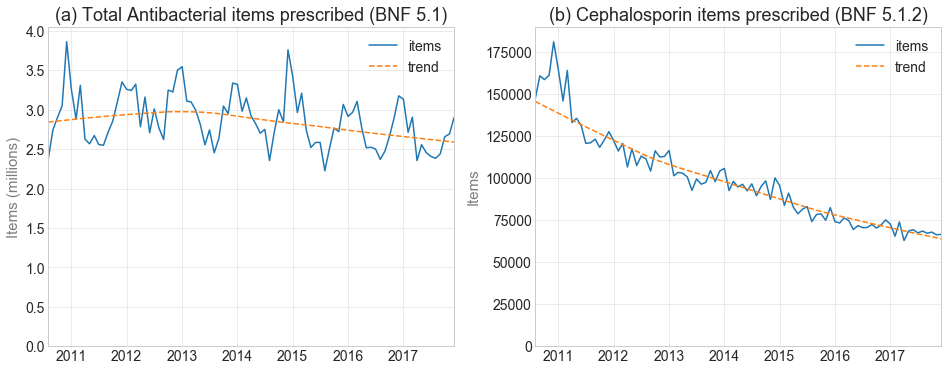

In [15]:
# total items in standard practices

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = all_antibiotics.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
#data = ooh.loc[all_antibiotics["month"]>"2010-09-01"]
data = all_antibiotics.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items'])
data['items'] = data["items"]/1000000

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items (millions)', size =15, alpha=0.6)
ax.set_title('(a) Total Antibacterial items prescribed (BNF 5.1)',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,data["items"].max()*1.05])
ax.legend(prop={'size': 14})
std_t = data

ax = plt.subplot(gs[0,1])
data = all_antibiotics.groupby('month').sum()[['cephalosporins','list_size']]
data = pd.DataFrame(data['cephalosporins'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(b) Cephalosporin items prescribed (BNF 5.1.2)',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,data['cephalosporins'].max()*1.05])
ax.legend(prop={'size': 14})
std_ceph = data

plt.show()

**Summary tables**

In [13]:
# smoothed median lines for percent broad spectrum:
smry2 = smry[["dates","percent_broad_spec"]].copy().rename(columns={"dates":"month"})
ooh2= pd.DataFrame(ooh_perc.copy()).reset_index(drop=True)
smry2['month'] = pd.to_datetime(smry2.month)
ooh2['month'] = pd.to_datetime(ooh2.month)
smry2 = smry2.merge(ooh2,on="month",suffixes=("_std","_ooh"))

smry2.loc[(smry2["month"]=="2010-10-01") |(smry2["month"]=="2017-12-01")].reset_index(drop=True)

,month,percent_broad_spec_std,percent_broad_spec_ooh
0,2010-10-01,13.575842,18.492309
1,2017-12-01,8.724635,10.938332


In [16]:
std = std_t.copy()
std["items"]= std["items"]*1000000

items = std.reset_index().merge(ooh_t.reset_index(),on="month",suffixes=("_std","_ooh"))
ceph = std_ceph.reset_index().merge(ooh_ceph.reset_index(),on="month",suffixes=("_std","_ooh"))

tab = pd.merge(items, ceph, on="month").reset_index(drop=True)
tab["year"] = tab.month.dt.year
tab = tab.loc[tab["year"]>2010].drop(["month"],axis=1).groupby("year").sum().astype("object")

tab["total_%"] = 100*tab["items_ooh"]/(tab["items_std"]+tab["items_ooh"])
tab["ceph_%"] = 100*tab["cephalosporins_ooh"]/(tab["cephalosporins_std"]+tab["cephalosporins_ooh"])

tab.append(pd.DataFrame(pd.Series(100*(tab.loc[2017]-tab.max(axis=0))/tab.max(axis=0),name="% change")).transpose())



,items_std,items_ooh,cephalosporins_std,cephalosporins_ooh,total_%,ceph_%
2011,3.44311e+07,1096595,1607041,63615,3.08659,3.80779
2012,3.68384e+07,1193982,1360642,54663,3.13938,3.86228
2013,3.52676e+07,1116774,1217102,44830,3.06938,3.55249
2014,3.53094e+07,1153880,1146603,41446,3.1645,3.48858
2015,3.33046e+07,1113538,984724,34182,3.23532,3.35477
2016,3.28715e+07,1097607,870839,26504,3.23119,2.95361
2017,3.15859e+07,1070210,816433,23142,3.27721,2.75639
% change,-14.2581,-10.3663,-49.1965,-63.6218,0,-28.6329


### Opportunity modelling

In [17]:
savings = all_antibiotics.loc[(all_antibiotics.list_size>1000) & (~pd.isnull(all_antibiotics.list_size)) & (all_antibiotics["month"]>="2017-01-01")]
savings = savings[['practice','pct','items','star_pu_items']]

savings = savings.groupby(['practice','pct'],as_index=False).agg({'items':'sum','star_pu_items':'mean'})
savings['rate'] = savings['items'] / savings['star_pu_items']
#savings = savings[['practice','pct','items','star_pu_items','rate']]
dec_1 = savings.rate.quantile(0.1)
print("£",format(dec_1*1000,'0,.0f'), " best decile, spend over last 12 months")
print("£",format(dec_1*1000/12,'0,.0f') , " best decile, spend per month")
savings['excess'] = savings.rate - dec_1
savings.loc[savings.excess<0,'excess'] = 0
savings['abs_excess'] = savings.excess * savings.star_pu_items
s2 = pd.DataFrame(savings.drop(["practice","pct"],axis=1).sum()).transpose()
s2["percent_saving"] = s2["abs_excess"]/s2["items"]
s2

£ 636  best decile, spend over last 12 months
£ 53  best decile, spend per month


,items,star_pu_items,rate,excess,abs_excess,percent_saving
0,31483480.0,3.312237e+07,7044.389764,2453.753359,1.080221e+07,0.343107


## CCG level

In [18]:
# remove practices with no STAR-PU
pc_ccg =  all_antibiotics.copy().loc[~pd.isnull(all_antibiotics.star_pu_items) & (all_antibiotics["month"]>"2010-09-01") ]
# group to CCGs
pc_ccg = pc_ccg.groupby(['pct','month'],as_index=False).sum()

pc_ccg["percent_broad_spec"] = (pc_ccg.all_broad_spectrum/pc_ccg.denom_broad_spectrum).fillna(0)
# deal with nulls
pc_ccg["three_day_courses"] = (pc_ccg.numerator_uti_course/pc_ccg.denominator_uti_course).fillna(0)
pc_ccg = pc_ccg.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc_ccg:
    if (pc_ccg[column].dtype == np.float64) | (pc_ccg[column].dtype == np.int32):
        pc_ccg["%s_per_thousand"%column] = pc_ccg[column]/(pc["list_size"]/1000)
    else:
        pc_ccg[column] = pc_ccg[column]
pc_ccg["items_per_starpu"] = pc_ccg["items"]/(pc_ccg["star_pu_items"]/1000)

pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})

pc_ccg.head(9)

,month,percentile,aminogylcosides,aminogylcosides_per_thousand,amoxicillin,amoxicillin_per_thousand,antileprotic,antileprotic_per_thousand,antituberculosis,antituberculosis_per_thousand,...,star_pu_items,star_pu_items_per_thousand,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_thousand,tetracyclines,tetracyclines_per_thousand,three_day_courses,three_day_courses_per_thousand,uti_items,uti_items_per_thousand
0,2010-10-01,0.1,0.0,0.000000,137.2,21.867248,0.0,0.000000,0.3,0.000000,...,3121.090068,328.223766,38.0,8.447183,39.2,5.454045,5.642266,0.434015,10.9,1.988342
1,2010-10-01,0.2,0.0,0.000000,2183.6,229.205318,3.0,0.446519,4.6,0.549350,...,70507.214552,7723.742247,640.8,71.342079,600.4,67.077139,5.972369,0.562671,184.8,22.960725
2,2010-10-01,0.3,1.0,0.084955,2638.7,332.595609,5.0,0.651566,9.0,1.020104,...,92192.588198,10512.947488,835.0,105.069022,711.0,94.336707,6.148594,0.657398,239.5,33.546132
3,2010-10-01,0.4,1.0,0.183117,3076.8,438.229782,7.0,0.864927,11.0,1.495141,...,107201.957923,13435.482382,933.6,129.828571,844.8,120.244293,6.280731,0.748023,297.8,42.418862
4,2010-10-01,0.5,2.0,0.281315,3663.0,570.143952,9.0,1.254355,15.0,2.238969,...,119229.344369,18007.958085,1105.5,164.789906,987.5,149.013544,6.417230,0.907973,349.5,52.324558
5,2010-10-01,0.6,3.0,0.431816,4340.6,671.807607,10.0,1.578394,18.0,2.864235,...,136326.700801,21638.917785,1226.8,198.856871,1127.4,181.836327,6.522719,1.073127,424.2,63.724593
6,2010-10-01,0.7,4.0,0.594997,4945.5,899.713318,11.1,2.052951,24.1,3.633675,...,154394.486686,30300.789036,1503.8,263.753278,1357.4,245.938226,6.636703,1.304935,524.1,88.467741
7,2010-10-01,0.8,5.0,0.928505,5526.4,1122.255704,15.0,2.669039,29.4,6.184067,...,178267.333735,36324.210947,1788.2,358.112695,1778.2,348.392702,6.758487,1.694009,645.0,132.236095
8,2010-10-01,0.9,8.0,1.571408,6808.0,1717.636712,19.7,3.800953,40.0,11.336574,...,232987.761724,62871.968132,2330.6,531.928296,2347.6,552.620667,7.032700,2.669861,931.8,211.133839


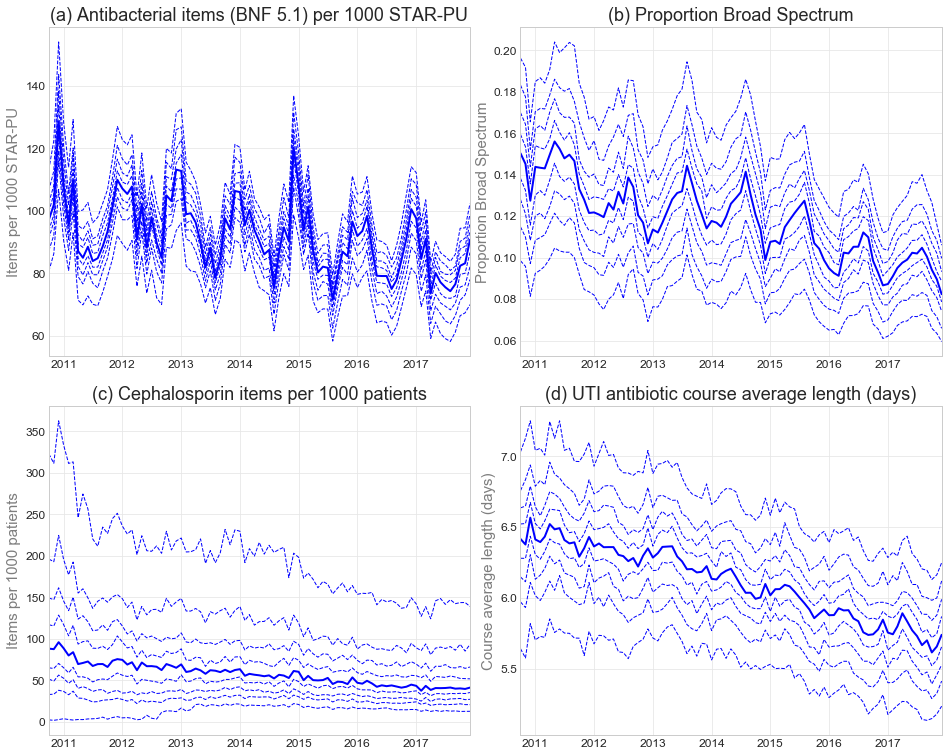

In [19]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]
x = pd.Series(x)

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per 1000 STAR-PU','Items per 1000 STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum','Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients','Items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)', 'Course average length (days)')]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
#plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# MAPS

In [20]:
#aggregate over last year
ccg_last_year =  all_antibiotics.copy().loc[~pd.isnull(all_antibiotics.star_pu_items) & (all_antibiotics["month"] >'2016-12-01') ]

#ccg_last_year = all_antibiotics_ccg.loc[all_antibiotics_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["star_pu_items"] = ccg_last_year["star_pu_items"]/12
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

ccg_last_year["percent_broad_spec"] = (100*ccg_last_year.all_broad_spectrum/ccg_last_year.denom_broad_spectrum).fillna(0)
# deal with nulls
ccg_last_year["three_day_courses"] = (ccg_last_year.numerator_uti_course/ccg_last_year.denominator_uti_course).fillna(0)
ccg_last_year = ccg_last_year.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in ccg_last_year:
    if (ccg_last_year[column].dtype == np.float64) | (ccg_last_year[column].dtype == np.int32):
        ccg_last_year["%s_per_thousand"%column] = ccg_last_year[column]/(ccg_last_year["list_size"]/1000)
    else:
        ccg_last_year[column] = ccg_last_year[column]
ccg_last_year["items_per_starpu"] = ccg_last_year["items"]/(ccg_last_year["star_pu_items"]/1000)

ccg_last_year = ccg_last_year.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)

ccg_last_year.head()

,setting,uti_items,tetracyclines,sulphonamides_trimethoprim,coamoxiclav,cephalosporins,quinolones,macrolides,metroni_tini_ornidazole,penicillins,...,metroni_tini_ornidazole_per_thousand,penicillins_per_thousand,flucloxacillin_per_thousand,antileprotic_per_thousand,antituberculosis_per_thousand,some_other_antibacterials_per_thousand,aminogylcosides_per_thousand,amoxicillin_per_thousand,items_per_thousand,items_per_starpu
pct,,,,,,,,,,,,,,,,,,,,,
00C,528,6697,9864,6081,1343,1544,1238,9725,1147,27268,...,10.627989,252.662595,63.313903,0.555954,0.185318,4.401303,0.055595,144.798239,594.852329,1033.214424
00D,1824,24004,32867,14716,3497,3894,2601,25565,4246,88248,...,14.579433,303.015979,80.180017,1.167453,0.374272,4.789993,0.051505,166.217903,680.663136,1172.898217
00J,1488,17170,27723,13384,3747,3871,2418,17354,2946,74381,...,11.467348,289.529135,77.165211,0.899171,0.326971,4.931816,0.089528,154.326530,626.951772,1093.240487
00K,1720,16607,27896,16922,4034,6188,2555,21468,4132,87080,...,13.938900,293.755916,72.980196,0.468903,0.445289,2.722336,0.026987,159.288707,622.419804,1096.455549
00L,2064,25305,40016,19128,8336,4080,2374,25575,2696,94218,...,8.401696,293.616846,76.151279,1.162401,0.891278,4.384713,0.183865,153.128393,672.537709,1122.582667


In [21]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,setting,uti_items,tetracyclines,sulphonamides_trimethoprim,coamoxiclav,cephalosporins,quinolones,macrolides,metroni_tini_ornidazole,...,penicillins_per_thousand,flucloxacillin_per_thousand,antileprotic_per_thousand,antituberculosis_per_thousand,some_other_antibacterials_per_thousand,aminogylcosides_per_thousand,amoxicillin_per_thousand,items_per_thousand,items_per_starpu,code
name,,,,,,,,,,,,,,,,,,,,,
NHS DARLINGTON CCG,00C,528,6697,9864,6081,1343,1544,1238,9725,1147,...,252.662595,63.313903,0.555954,0.185318,4.401303,0.055595,144.798239,594.852329,1033.214424,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,1824,24004,32867,14716,3497,3894,2601,25565,4246,...,303.015979,80.180017,1.167453,0.374272,4.789993,0.051505,166.217903,680.663136,1172.898217,00D
NHS NORTH DURHAM CCG,00J,1488,17170,27723,13384,3747,3871,2418,17354,2946,...,289.529135,77.165211,0.899171,0.326971,4.931816,0.089528,154.326530,626.951772,1093.240487,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,1720,16607,27896,16922,4034,6188,2555,21468,4132,...,293.755916,72.980196,0.468903,0.445289,2.722336,0.026987,159.288707,622.419804,1096.455549,00K
NHS NORTHUMBERLAND CCG,00L,2064,25305,40016,19128,8336,4080,2374,25575,2696,...,293.616846,76.151279,1.162401,0.891278,4.384713,0.183865,153.128393,672.537709,1122.582667,00L


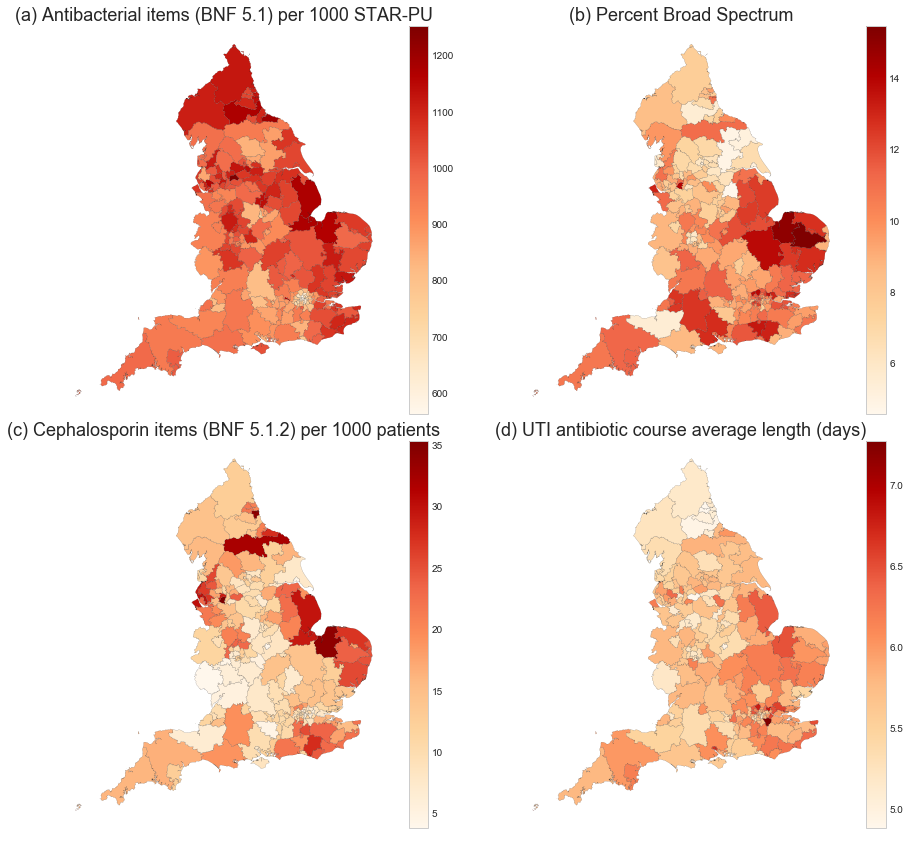

In [22]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per 1000 STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Percent Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items (BNF 5.1.2) per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

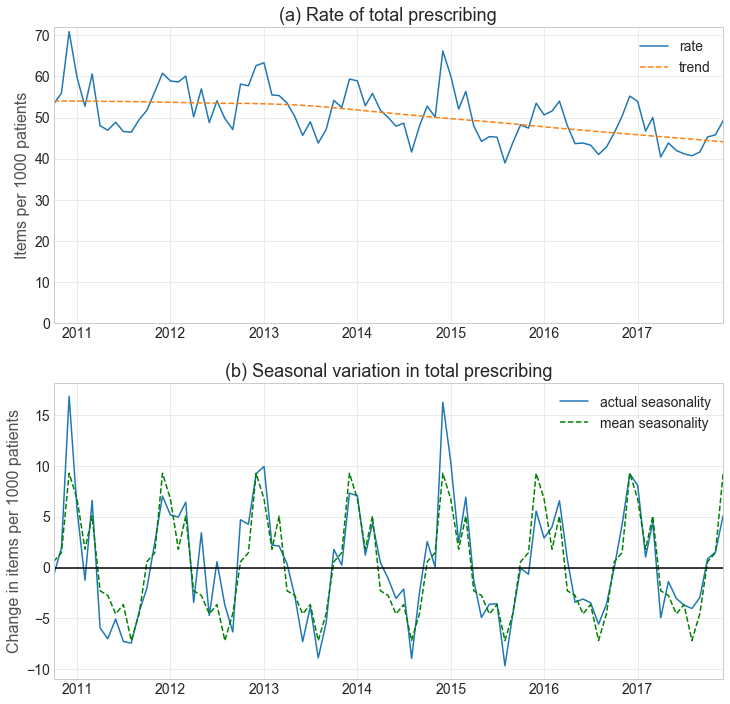

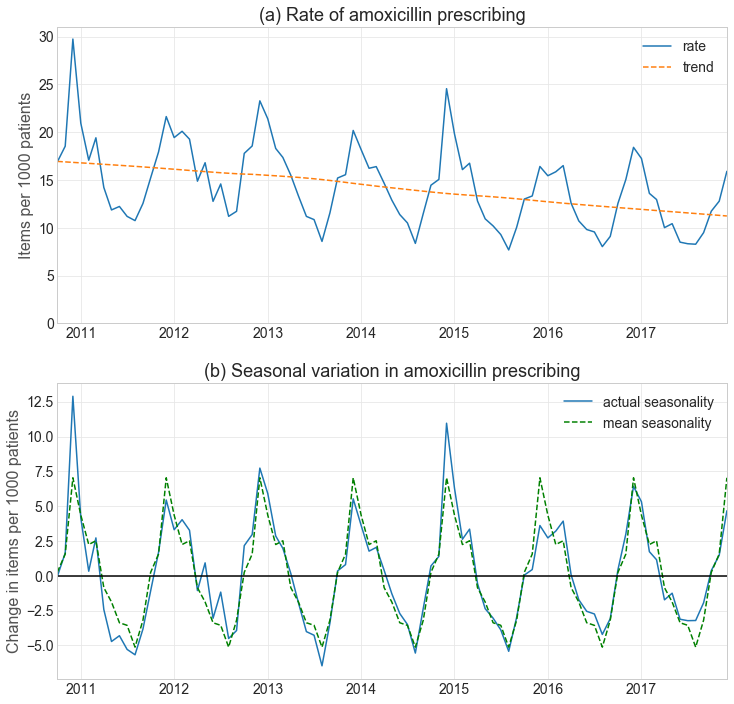

Typical amoxicillin seasonal variation 12.2 per 1000 patients


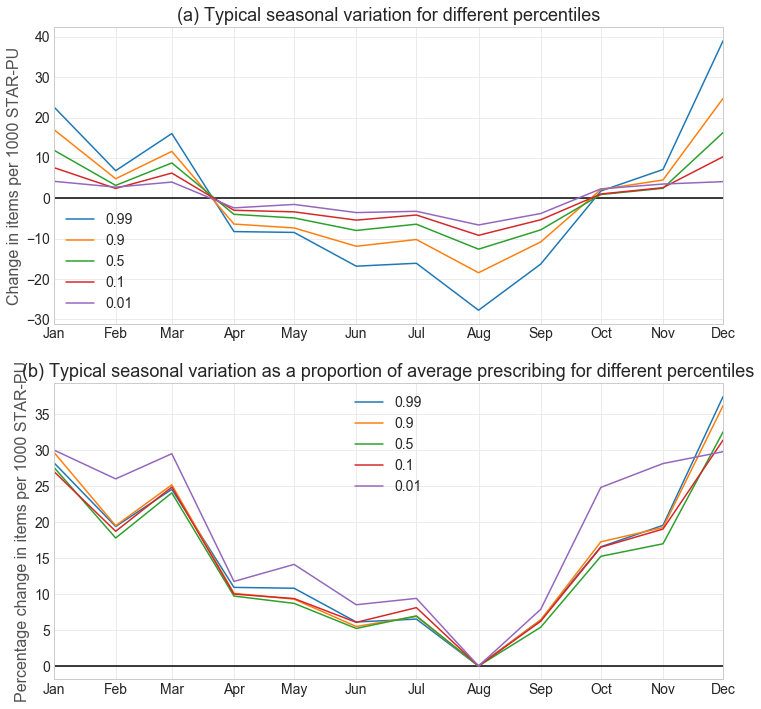

In [23]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]


'''fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(5,1)  # grid layout for subplots

for i in s:
#for decile in [0.01,0.1,0.5,0.9,0.99]:
    ax = plt.subplot(gs[i[2], i[3]])
    print(dfp['percentile'])
    print(i[4])
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    #data.info()
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')


    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    #calc.plot()
    #plt.show()

    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    calc.seasonal = (calc.seasonal/average)*100
    flat = ((data.items_per_starpu-calc.trend)/data.items_per_starpu)*100
    #if decile == .5:
    #    ax.plot(data["dates"],res,'b-',linewidth=2)


    ax.plot(flat,label='actual seasonality')
    ax.plot(calc.seasonal,label='mean seasonality')
    ax.set_ylabel('Percentage change', size =16, alpha=0.8)
    ax.set_title('Percentile: %s'%(i[4]),size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    ax.set_ylim([-30,30])
    ax.legend(prop={'size': 14})


plt.show()'''
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items']/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,72])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.savefig('seasonal_variation_total.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['amoxicillin','list_size']]
data = pd.DataFrame(data.amoxicillin/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,31])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.show()
print("Typical amoxicillin seasonal variation %s per 1000 patients"%(round(calc.seasonal[0].max()-calc.seasonal[0].min(),1)))

s = [(0,'items_per_starpu',0,0,0.99),
     (1,'items_per_starpu',1,0,0.9),
     (2,'items_per_starpu',2,0,0.5),
     (3,'items_per_starpu',3,0,0.1),
     (4,'items_per_starpu',4,0,0.01)]
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots
ax = plt.subplot(gs[0,0])
ax.axhline(0,color='black')
ax2 = plt.subplot(gs[1,0])
ax2.axhline(0,color='black')
for i in s:
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    august = pd.DataFrame(data.items_per_starpu.reset_index().loc[pd.DatetimeIndex(data.reset_index()['month']).month==8])
    #average = august.sum() / (len(august))
    #average = average.items_per_starpu
    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    minimum = calc.seasonal.min()
    
    ax.plot(calc.seasonal,label=i[4])
    ax.set_ylabel('Change in items per 1000 STAR-PU', size =16, alpha=0.8)
    ax.set_title('(a) Typical seasonal variation for different percentiles',size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax.set_ylim([-20,25])
    ax.legend(prop={'size': 14})
    ax.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
    
    calc.seasonal = ((calc.seasonal-minimum) / average) * 100
    
    ax2.plot(calc.seasonal,label=i[4])
    ax2.set_ylabel('Percentage change in items per 1000 STAR-PU', size =16, alpha=0.8)
    ax2.set_title('(b) Typical seasonal variation as a proportion of average prescribing for different percentiles',size = 18)
    ax2.tick_params(labelsize=14)
    ax2.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax2.set_ylim([-20,25])
    ax2.legend(prop={'size': 14})
    ax2.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax2.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
plt.show()

In [24]:
# practice-level data restricted to those with >1000 patients
qdf = all_antibiotics.copy()
qdf = qdf.loc[(qdf.list_size>1000) & (~pd.isnull(qdf.star_pu_items)) & (qdf["month"]>"2010-09-01") ]

# Assign months to seasons - use numbers so that decomposition function can recognise them as dates.
import datetime as dt
qdf["monthno"] = qdf.month.dt.month # extract month as a number
qdf["year"] = qdf.month.dt.year.astype(int)

conditions = [
    (qdf['monthno']<=2 ),
    (qdf['monthno']<=5 ),
    (qdf['monthno']<=8 ),
    (qdf['monthno']<=11 )]
choices = [("01"),("04"),("07"),("10")]
qdf['season'] = np.select(conditions, choices, default="01")
qdf["season_yr"]= np.where(qdf["monthno"]==1, qdf["year"]-1,qdf["year"])
#qdf['dates'] = qdf["season_yr"].astype(str)+"-"+qdf["season"]+"-"+"01"
qdf = qdf.loc[(qdf["season"]!="04") & (qdf["season"]!="10") & (qdf["season_yr"]!=2010)]
qdf = qdf.drop(["monthno","setting"],axis=1)

# group data by season
qdf = qdf.groupby(["season_yr","season","practice"]).mean()
qdf = qdf.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

# calculate prescribing rate per 1,000 STAR-PU & rearrange data:
qdf["items_per_starpu"] = 1000*qdf["items"]/qdf["star_pu_items"]
qdf["amox_per_starpu"] = 1000*qdf["amoxicillin"]/qdf["star_pu_items"]
qdf["fluc_per_starpu"] = 1000*qdf["flucloxacillin"]/qdf["star_pu_items"]

# make a separate table for fluc & amox:
qdfa = qdf.reset_index()[["practice","season_yr","season","amox_per_starpu","fluc_per_starpu"]]

# rearrange data
qdf = qdf.reset_index()[["practice","season_yr","season","items_per_starpu"]]
qdf = qdf.groupby(["practice","season_yr","season"]).mean().unstack().reset_index(col_level=1)
qdf.columns = qdf.columns.droplevel()

# exclude practices for any year in which they do not have data for both seasons:
qdf = qdf.loc[(pd.notnull(qdf["01"])) & (pd.notnull(qdf["07"]))] 
# assign practices to deciles for summer period; find their absolute increase in prescribing rate in winter:
qdf["decile_summer"] = qdf.groupby(["season_yr"])["07"].rank(pct=True)
qdf["decile_summer"] = np.floor(qdf["decile_summer"]*10-0.00000001).astype(int)
qdf["winterpeak_abs"] = qdf["01"]-qdf["07"]

# find mean increase for each decile, then tranlsate to percentage
qdf = qdf.groupby(["decile_summer","season_yr"]).mean().reset_index()
qdf["winterpeak (%)"] = 100*qdf["winterpeak_abs"]/qdf["07"]

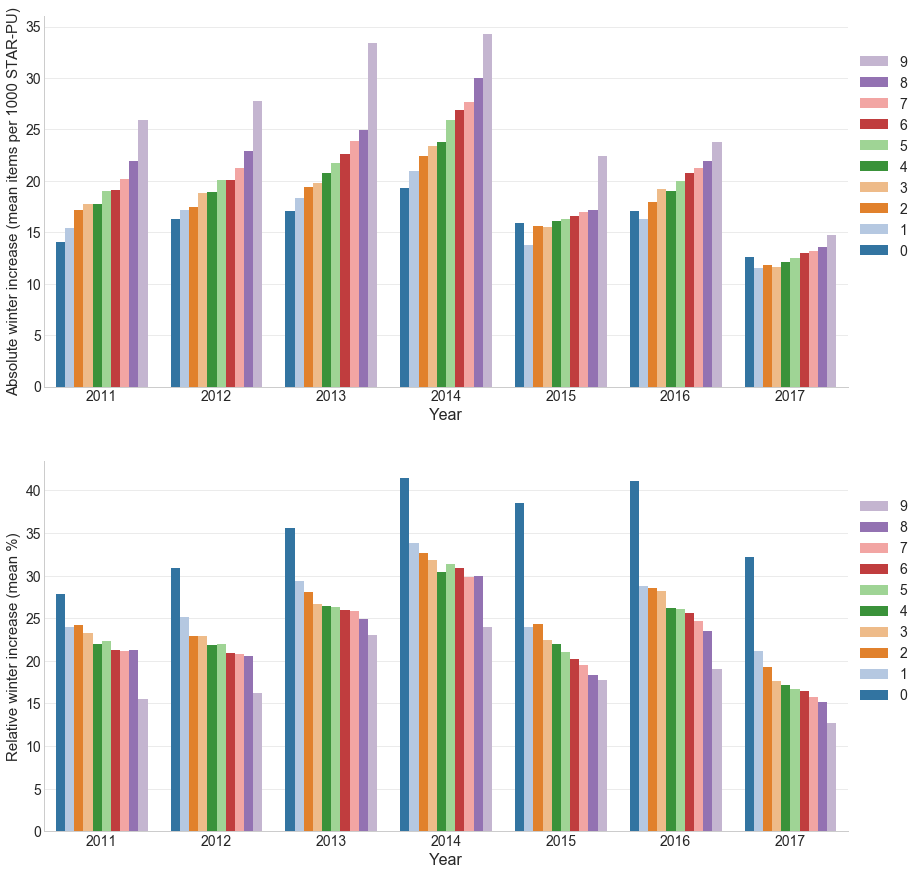

In [25]:
dfp = qdf[["season_yr","decile_summer","winterpeak_abs","winterpeak (%)"]].sort_values(by=["season_yr","decile_summer"])
data = dfp.copy()

fig = plt.figure(figsize=(16,15)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots

s = [(0,'winterpeak_abs',"Absolute winter increase (mean items per 1000 STAR-PU)"),
     (1,'winterpeak (%)',"Relative winter increase (mean %)")]

for i in s:
    ax = plt.subplot(gs[i[0],0])
    sns.barplot(x="season_yr", y=i[1], hue="decile_summer", data=data, palette="tab20", ax=ax)

    ax.set_ylabel(i[2],size=15)
    ax.set_xlabel("Year",size=16)
    ax.tick_params(labelsize=14)

    sns.despine(ax=ax, right=True, left=False)

    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', fontsize="14",bbox_to_anchor=(1, .62))
    
plt.show()

# Merge data for regression model (see Stata code)

In [26]:
last_year = all_antibiotics.loc[(all_antibiotics.list_size>1000) & (~pd.isnull(all_antibiotics.list_size)) & (all_antibiotics["month"]>="2017-01-01")]
last_year = last_year[['practice','pct','items','list_size']]
last_year = last_year.groupby(['practice','pct'],as_index=False).agg({'items':'sum','list_size':'mean'})
last_year['rate'] = last_year['items'] / (last_year['list_size'] / 1000)
last_year['monthly_rate'] = last_year['rate']/12
last_year = last_year[['practice','pct','items','rate','monthly_rate']]
last_year.rate.quantile([0.1,0.5,0.9])

0.1    331.058519
0.5    539.316533
0.9    707.395047
Name: rate, dtype: float64

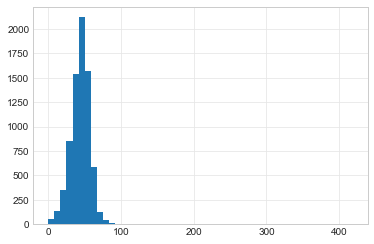

In [27]:
last_year.monthly_rate.hist(bins=50)
plt.show()

In [28]:
phe = pd.read_csv('indicators-GP.data.csv')

mask = (phe['Indicator Name'] == 'Deprivation score (IMD 2015)') & (phe['Area Type'] == 'GP')
imd = phe.loc[mask, ['Area Code','Value']]
imd = imd.set_index('Area Code')
imd.hist()
plt.show()

mask = (phe['Indicator Name'] == '% who would recommend practice') & (phe['Area Type'] == 'GP') & (phe['Time period'] == '2015/16')
satisfaction = phe.loc[mask, ['Area Code','Value']]
satisfaction = satisfaction.set_index('Area Code')
satisfaction.hist()
plt.show()

mask = (phe['Indicator Name'] == '% with a long-standing health condition') & (phe['Area Type'] == 'GP') & (phe['Time period'] == '2015/16')
long_term_health = phe.loc[mask, ['Area Code','Value']]
long_term_health = long_term_health.set_index('Area Code')
long_term_health.hist()
plt.show()

mask = (phe['Indicator Name'] == '% aged 65+ years') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2016)
over_65 = phe.loc[mask, ['Area Code','Value']]
over_65 = over_65.set_index('Area Code')
over_65.hist()
plt.show()

mask = (phe['Indicator Name'] == '% aged under 18 years') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2016)
under_18 = phe.loc[mask, ['Area Code','Value']]
under_18 = under_18.set_index('Area Code')
under_18.hist()
plt.show()

FileNotFoundError: File b'indicators-GP.data.csv' does not exist

In [25]:
qof = pd.read_csv('ACHIEVEMENT_EXCEPTIONS.csv')
qof_map = pd.read_csv('INDICATOR_MAPPINGS.csv')
qof = qof.merge(qof_map[['INDICATOR_CODE','DOMAIN_CODE']], how='inner', on='INDICATOR_CODE', copy=False)
qof_all = qof.loc[qof.MEASURE == 'ACHIEVED_POINTS'].groupby(['PRACTICE_CODE','DOMAIN_CODE']).sum()
qof_all = qof_all.unstack(level=1) #.reset_index(col_level=0)
qof_all.columns = qof_all.columns.droplevel(0)
qof_all['TOTAL'] = qof_all['CL'] + qof_all['PH'] + qof_all['PHAS']
qof_all.head(10)

DOMAIN_CODE,CL,PH,PHAS,TOTAL
PRACTICE_CODE,,,,
A81001,425.69,97.00,24.0,546.69
A81002,435.00,97.00,27.0,559.00
A81003,425.34,97.00,27.0,549.34
A81004,427.63,97.00,27.0,551.63
A81005,429.72,91.76,27.0,548.48
A81006,425.72,97.00,27.0,549.72
A81007,430.68,97.00,27.0,554.68
A81008,428.28,97.00,27.0,552.28
A81009,434.00,87.00,27.0,548.00


In [26]:
q = '''
SELECT
  code,
  dispensing_patients
FROM
  ebmdatalab.bsa.dispensing_practices_jan2017
ORDER BY
  code ASC
'''
dispensing = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
dispensing.head(5)

,code,dispensing_patients
0,A81001,0
1,A81002,0
2,A81004,0
3,A81005,0
4,A81006,0


In [27]:
q = '''
SELECT
  practice,
  SUM(items) AS total_items
FROM
  ebmdatalab.hscic.normalised_prescribing_legacy
WHERE
  month >= TIMESTAMP("2016-07-01")
  AND month <= TIMESTAMP("2017-06-01")
GROUP BY
  practice
'''
precribing_volume = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
precribing_volume.head(5)

,practice,total_items
0,Y02045,10061
1,Y03881,30215
2,N81051,190366
3,Y01108,46979
4,N81063,227714


In [28]:
q = '''
SELECT
  *
FROM
  ebmdatalab.ONS.practices_rural_urban
'''
urban_rural = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
urban_rural.head(5)

,code,rural_urban_code
0,A81001,4
1,A81002,4
2,A81003,4
3,A81004,4
4,A81005,3


In [29]:
q = '''
SELECT
  practice,
  --pct_id as pct,
  AVG(total_list_size) as list_size
FROM
  [ebmdatalab:hscic.practice_statistics]
WHERE
  month >= TIMESTAMP("2016-07-01")
  AND month <= TIMESTAMP("2017-06-01")
GROUP BY
  practice,
  --pct
ORDER BY
  practice
'''
list_size = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
list_size.head(5)

,practice,list_size
0,A81001,4196.333333
1,A81002,19940.750000
2,A81003,3287.000000
3,A81004,9252.666667
4,A81005,7923.750000


In [30]:
gps_per_practice = pd.read_csv('gps_per_practice_sept_2017.csv')
gps_per_practice

,practice,num_gps
0,A81001,NaN
1,A81002,12.0
2,A81004,3.0
3,A81005,9.0
4,A81006,8.0
5,A81007,10.0
6,A81009,5.0
7,A81011,5.0
8,A81012,2.0
9,A81013,4.0


In [31]:
measures = {'ktt9_cephalosporins':'Antibiotic stewardship: co-amoxiclav, cephalosporins &amp; quinolones (KTT9)',
            'ktt9_uti_antibiotics':'Antibiotic stewardship: three-day courses for uncomplicated UTIs (KTT9)',
            #'ktt9_antibiotics':'Antibiotic stewardship: volume of antibiotic prescribing (KTT9)',
            'ciclosporin':'Ciclosporin and tacrolimus oral preparations prescribed generically',
            'coproxamol':'Co-proxamol',
            'desogestrel':'Desogestrel prescribed as a branded product',
            'diltiazem':'Diltiazem preparations (>60mg) prescribed generically',
            #'doacs':'Direct Oral Anticoagulants (DOACs)',
            'quetiapine':'Extended-release quetiapine',
            'glaucoma':'Glaucoma eye drops prescribed by brand',
            'ace':'High-cost ACE inhibitors',
            'arb':'High-cost ARBs',
            'sildenafil':'High-cost drugs for erectile dysfunction',
            'ppi':'High-cost PPIs',
            'statins':'High-cost statins',
            'icsdose':'High dose inhaled corticosteroids',
            'opioidspercent':'High dose opioids as percentage regular opioids',
            'opioidper1000':'High dose opioids per 1000 patients',
            'ppidose':'Higher dose Proton Pump Inhibitors (PPIs)',
            'keppra':'Keppra vs. levetiracetam',
            'ktt12_diabetes_insulin':'Long-acting insulin analogues (KTT12)',
            'statinintensity':'Low and medium intensity statins',
            'methotrexate':'Methotrexate 10 mg tablets',
            'nebivolol':'Nebivolol 2.5mg tablets',
            'lpzomnibus':'NHS England Low Priority Treatment - All Low Priority Treatments',
            #'lpcoprox':'NHS England Low Priority Treatment - co-proxamol',
            #'lpdosulepin':'NHS England Low Priority Treatment - dosulepin',
            #'lpdoxazosin':'NHS England Low Priority Treatment - doxazosin modified release',
            #'lpfentanylir':'NHS England Low Priority Treatment - fentanyl immediate release',
            #'lpglucosamine':'NHS England Low Priority Treatment - glucosamine and chondroitin',
            #'lpglutenfree':'NHS England Low Priority Treatment - gluten free products',
            #'lphomeopathy':'NHS England Low Priority Treatment - homeopathy',
            #'lplidocaine':'NHS England Low Priority Treatment - lidocaine plasters',
            #'lpliothyronine':'NHS England Low Priority Treatment - liothyronine',
            #'lplutein':'NHS England Low Priority Treatment - lutein and antioxidants',
            #'lpomega3':'NHS England Low Priority Treatment - omega-3 fatty acid compounds',
            #'lpoxycodone':'NHS England Low Priority Treatment - oxycodone and naloxone combination product',
            #'lptramadolpara':'NHS England Low Priority Treatment - paracetamol and tramadol combination',
            #'lpperindopril':'NHS England Low Priority Treatment - perindopril arginine',
            #'lprubefacients':'NHS England Low Priority Treatment - rubefacients',
            #'lptadalafil':'NHS England Low Priority Treatment - tadalafil once daily',
            #'lptravelvacs':'NHS England Low Priority Treatment - travel vaccines',
            #'lptrimipramine':'NHS England Low Priority Treatment - trimipramine',
            'ktt13_nsaids_ibuprofen':'Non-preferred NSAIDs and COX-2 inhibitors (KTT13)',
            'ktt3_lipid_modifying_drugs':'Other lipid-modifying drugs (KTT3)',
            'lyrica':'Pregabalin prescribed as Lyrica',
            'dipyridamole':'Prescribing of dipyridamole',
            'tramadol':'Prescribing of high cost tramadol preparations ',
            #'pregabalin':'Prescribing of pregabalin',
            #'pregabalinmg':'Prescribing of pregabalin (total mg)',
            'trimethoprim':'Prescribing of trimethoprim vs nitrofurantoin',
            'saba':'Short acting beta agonist inhalers',
            'silver':'Silver dressings',
            'solublepara':'Soluble/effervescent forms of paracetamol and co-codamol',
            'fungal':'Topical treatment of fungal nail infections',
            'vitb':'Vitamin B complex'}

In [32]:
all_measures = []
for measure, label in measures.items():
    q = '''
    SELECT
      practice_id,
      AVG(percentile) as mean_percentile
    FROM
      ebmdatalab.measures.practice_data_%s
    WHERE
      month >= "2017-01-01"
      AND month <= "2017-12-01"
    GROUP BY
      practice_id
    ''' % (measure)

    df = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
    df['measure'] = measure
    all_measures.append(df)
    del df
all_measures = pd.concat(all_measures)
all_measures.head()

,practice_id,mean_percentile,measure
0,A81605,NaN,ppidose
1,A82057,NaN,ppidose
2,A82635,NaN,ppidose
3,A83068,NaN,ppidose
4,A85025,NaN,ppidose


In [33]:
all_measures

,practice_id,mean_percentile,measure
0,A81605,NaN,ppidose
1,A82057,NaN,ppidose
2,A82635,NaN,ppidose
3,A83068,NaN,ppidose
4,A85025,NaN,ppidose
5,A85601,NaN,ppidose
6,A89618,NaN,ppidose
7,A89625,NaN,ppidose
8,B81686,NaN,ppidose
9,B81689,NaN,ppidose


In [34]:
summ_measures = all_measures.groupby('practice_id').mean()
summ_measures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8187 entries, A81001 to Y05857
Data columns (total 1 columns):
mean_percentile    7608 non-null float64
dtypes: float64(1)
memory usage: 127.9+ KB


In [35]:
# urban_rural
# qof_all.
# imd.
# satisfaction.
# long_term_health.
# over_65.
# dispensing.
# precribing_volume.

all = last_year.merge(urban_rural,
                how='left',
                left_on='practice',
                right_on='code',
                copy=False)

all = all.merge(summ_measures,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)

all = all.merge(gps_per_practice,
                how='left',
                on='practice',
                copy=False)

all = all.merge(qof_all,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)

all = all.merge(imd,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)
all = all.merge(satisfaction,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_imd', ''))
all = all.merge(long_term_health,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_satisfaction', ''))
all = all.merge(over_65,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_long_term_health', ''))
all = all.merge(under_18,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_over_65', '_under_18'))
all = all.merge(dispensing,
                how='left',
                left_on='practice',
                right_on='code',
                copy=False)
all = all.merge(precribing_volume,
                how='left',
                left_on='practice',
                right_on='practice',
                copy=False)

all.to_csv('antibiotics_for_analysis.csv')
all.describe()
all.head()

,practice,pct,items,rate,code_x,rural_urban_code,mean_percentile,num_gps,CL,PH,PHAS,TOTAL,Value_imd,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,code_y,dispensing_patients,total_items
0,A81001,00K,2455,49.173761,A81001,4,0.400915,NaN,425.69,97.00,24.0,546.69,29.140310,76.020488,57.895013,22.674829,19.722157,A81001,0.0,90945
1,A81002,00K,13413,56.040210,A81002,4,0.463429,12.0,435.00,97.00,27.0,559.00,29.689706,85.166335,58.872464,21.025589,18.776949,A81002,0.0,455226
2,A81004,00M,5658,49.256967,A81004,4,0.452341,3.0,427.63,97.00,27.0,551.63,34.411828,72.955168,50.053075,18.898240,18.135315,A81004,0.0,191940
3,A81005,00M,4791,50.172268,A81005,3,0.351087,9.0,429.72,91.76,27.0,548.48,15.743812,85.118831,52.133158,26.626843,17.585155,A81005,0.0,196498
4,A81006,00K,9051,54.478479,A81006,4,0.398236,8.0,425.72,97.00,27.0,549.72,31.791515,85.096769,51.838239,18.484408,20.861205,A81006,0.0,321726
